<a href="https://colab.research.google.com/github/hiwasaki1712/ml_edu_notes/blob/main/decisionBoundary_iris_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# アヤメデータ分類モデルの決定境界を可視化するサンプル

分類問題とは、与えられたデータを見て各クラスをうまく分けられる境界を決めること、と言える。

典型的な例として、超有名データを古典的な機械学習の代表的な手法で分類し、その決定境界を可視化する流れを紹介する。  
* iris データに複数の教師あり多値分類を適用。
  * 説明変数は可視化のため、花弁（petal）の2値のみ使用
* 各モデルの決定境界を可視化
* 各モデルの可視化や特徴重要度などを観察

___

irisデータ  
アヤメの花の花弁（petal）とがく（sepal）の長さと幅のデータ



In [2]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.metrics import classification_report
from sklearn.inspection import DecisionBoundaryDisplay


print (np.__version__)
print (pd.__version__)
print (matplotlib.__version__)
print (sklearn.__version__)

1.26.4
2.2.2
3.8.0
1.5.2


決定境界の可視化のため、ここではirisデータの4個ある特徴量の中から2個を説明変数として使用する。

* 花弁(petal)の特徴量は比較的分布がきれいに分かれていて分類しやすい。  
* がく(sepal)の特徴量は分布が重なっていて分類の難易度が上がる。  
次のセルでは、どちらの特徴量を使うかコメントアウトして選べるようにした。両方試して結果の違いを比べてみよう。

In [ ]:
### データの読み込み
iris = load_iris()

### 説明変数　petalの2変数のみ使用する場合（クラスの分離は簡単）
# df_iris = pd.DataFrame(iris.data[:, 2:], columns=iris.feature_names[2:])
### 説明変数　setalの2変数のみ使用する場合（クラス1と2の分離が難しい）
df_iris = pd.DataFrame(iris.data[:, :2], columns=iris.feature_names[:2])

### 目的変数
df_iris['target'] = iris.target


df_iris.head()

,sepal length (cm),sepal width (cm),target
0,5.1,3.5,0
1,4.9,3.0,0
2,4.7,3.2,0
3,4.6,3.1,0
4,5.0,3.6,0


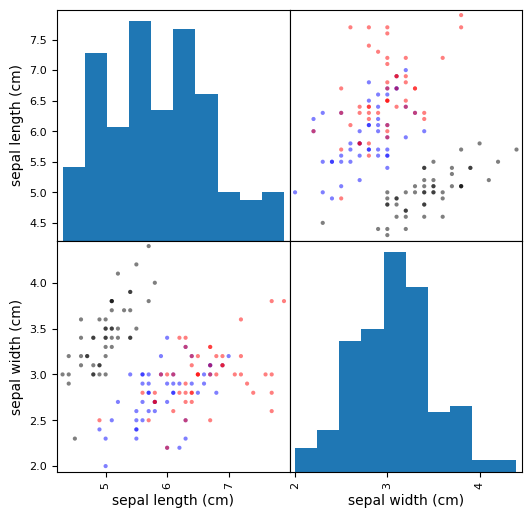

In [ ]:
### 各クラスの色を定義
color_dict = {0:'black', 1:'blue', 2:'red'}
color = df_iris['target'].map(color_dict)

### データセットのペアプロットを表示
scatter_matrix(df_iris.drop(columns=['target']),
               color=color,
               figsize=(6,6))
plt.show()

In [ ]:
### データセットを train-test 分割
df_train, df_test = train_test_split(df_iris,
                 test_size=0.2,
                 stratify=df_iris['target'])

X_train = df_train.drop(columns=['target'])
y_train = df_train['target']
X_test = df_test.drop(columns=['target'])
y_test = df_test['target']

In [ ]:
### 説明変数を標準化（平均0、分散1になるようデータ分布を正規化する）

scaler = StandardScaler()
### train データで標準化スケールを決めて、実行
X_train = scaler.fit_transform(X_train)
### test データを、train と同じスケールで標準化
X_test = scaler.transform(X_test)

### Pandas データフレームに変換
X_train = pd.DataFrame(X_train, columns=df_iris.columns[:-1])
X_test = pd.DataFrame(X_test, columns=df_iris.columns[:-1])

X_train.describe()

,sepal length (cm),sepal width (cm)
count,1.200000e+02,1.200000e+02
mean,-9.029814e-16,7.549517e-16
std,1.004193e+00,1.004193e+00
min,-1.828425e+00,-2.555151e+00
25%,-8.607909e-01,-5.689608e-01
50%,-1.411133e-02,-7.241319e-02
75%,7.116140e-01,6.724082e-01
max,2.284019e+00,2.658599e+00


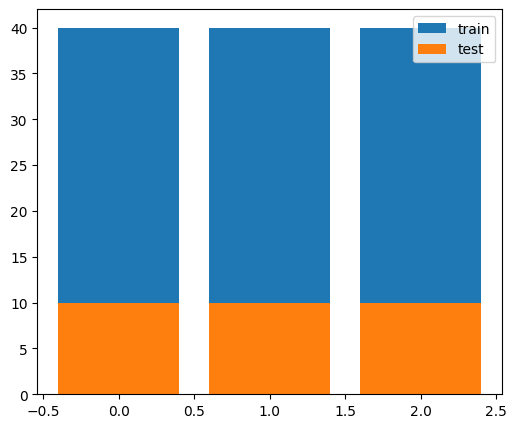

In [ ]:
### 分割したデータの各クラスの割合が train-test で均等か確認
plt.figure(figsize=(6, 5))
plt.bar(df_train['target'].unique(), df_train['target'].value_counts(), label='train')
plt.bar(df_test['target'].unique(), df_test['target'].value_counts(), label='test')
plt.legend()
plt.show()

## 各分類モデルの決定境界を比較

In [ ]:
### 各モデルを定義
random_state = 137

classifiers = {
    'lr':   LogisticRegression(random_state=random_state),
    'tree': DecisionTreeClassifier(max_depth=3,
                                   random_state=random_state),
    'lgb':  lgb.LGBMClassifier(n_estimators=100,
                               verbose=-1,
                               random_state=random_state),
    'rf':   RandomForestClassifier(n_estimators=100,
                                   random_state=random_state,),
    'svm':  SVC(random_state=random_state,
                kernel='rbf'),
    'knn':  KNeighborsClassifier(n_neighbors=5)
}

In [ ]:
### 各モデルを訓練
for ky in classifiers.keys():
    clf = classifiers[ky]
    clf.fit(X_train, y_train)

    ### Test データの正解率
    print (f'{ky:4}: {clf.score(X_test, y_test):.3f}')

lr  : 0.933
tree: 0.833
lgb : 0.800
rf  : 0.733
svm : 0.900
knn : 0.767


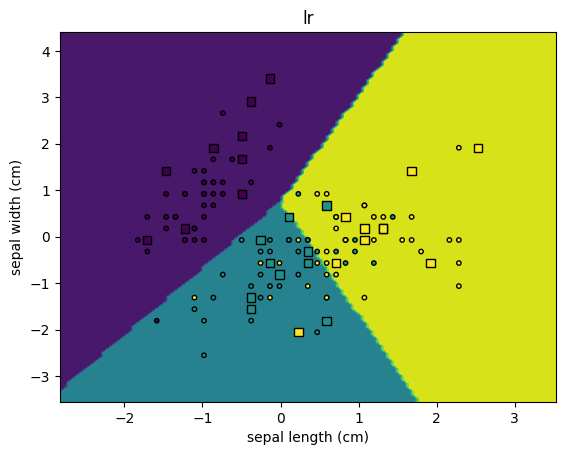

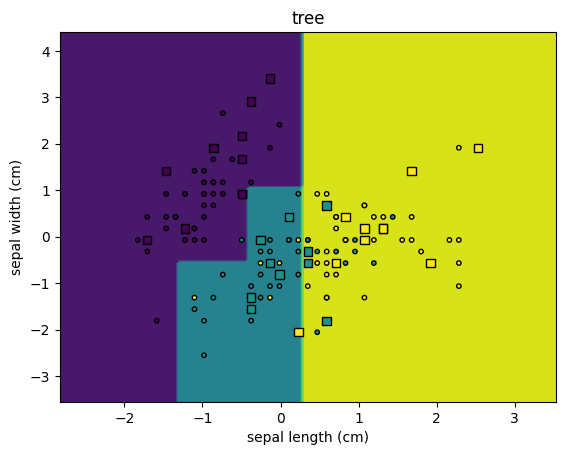

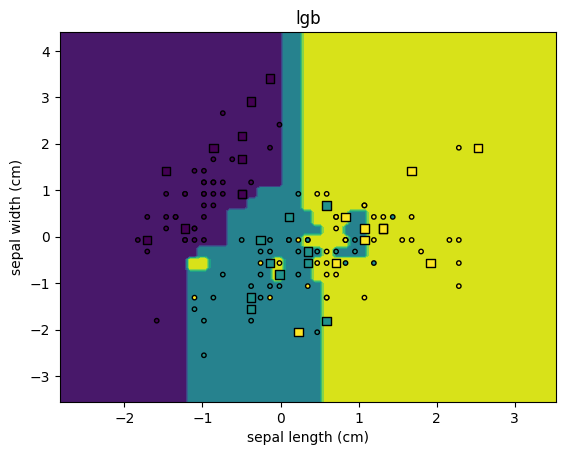

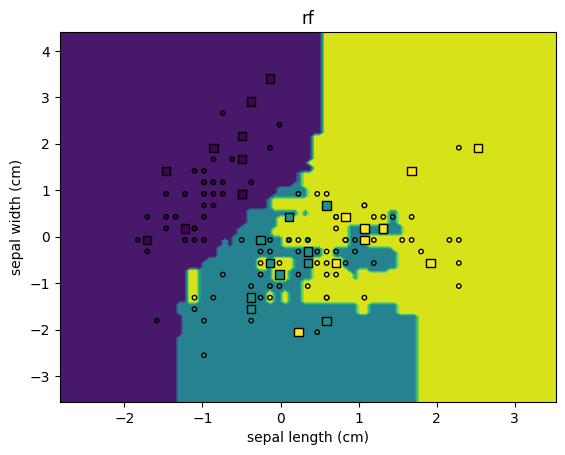

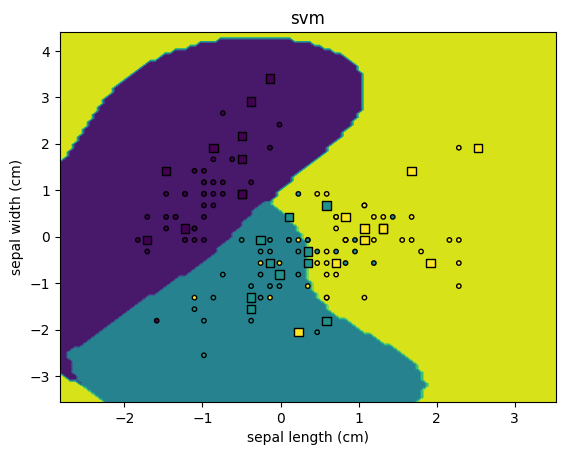

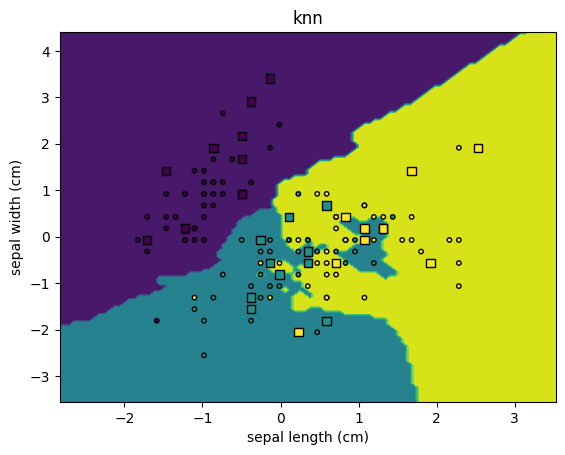

In [ ]:
### 各モデルの決定境界をプロット

### train-test データを結合
X_combined = pd.concat((X_train, X_test), axis=0)

for ky in classifiers.keys():
    clf = classifiers[ky]

    ### 決定境界をプロット
    display = DecisionBoundaryDisplay.from_estimator(clf, X_combined, )

    ### train データをプロット
    display.ax_.scatter(X_train.iloc[:, 0],
                        X_train.iloc[:, 1],
                        c=y_train, edgecolor="k", marker='o', s=10)
    ### test データをプロット
    display.ax_.scatter(X_test.iloc[:, 0],
                        X_test.iloc[:, 1],
                        c=y_test, edgecolor="k", marker='s')
    ### タイトル
    display.ax_.set_title(f'{ky}')
    plt.show()

描いた決定境界を観察してみよう

* Logistic 回帰  
Logistic 回帰は線系の関数（つまり比例の式）を使う。  
斜めの直線でデータ分布を区切っている。


* Tree 系 (決定木、random forest、LightGBM)  
決定木は、ある1個の説明変数に対する2択の判定を繰り返して階層的な判定モデルを作る。  
水平・垂直の直線でカクカクした境界を作っている。  
Random forest と LightGBM は、
特に1 と 2 の分布が込み合っている部分を細かく境界で区切って、2 つのクラスのデータ点をできるだけ分離しようとしている。  


* SVM  
カーネル関数でデータを高次元空間へ射影し、線系の決定境界でクラスを分離する。  
元のデータ空間では曲線的な境界になる。

* kNN  
最も近いk個のデータ点のクラスラベルの多数決で決まる。  
特にデータ分布が込み合っているところでグネグネした境界になっている。



### 過学習時の決定境界の例　決定木
決定木は深くすれば、より細かく入り組んだ境界を作るようになる。

どのモデルでも決定境界をtrainデータ点に合わせてより細かく引いていけば、完全に分類することができるようになる。しかしtrainに合わせすぎると、未知のtestデータを正しく分類できなくなる。これが過学習。

Train acc: 0.9583333333333334
Test acc:  0.6666666666666666
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.50      0.80      0.62        10
           2       0.67      0.40      0.50        10

    accuracy                           0.67        30
   macro avg       0.72      0.67      0.67        30
weighted avg       0.72      0.67      0.67        30



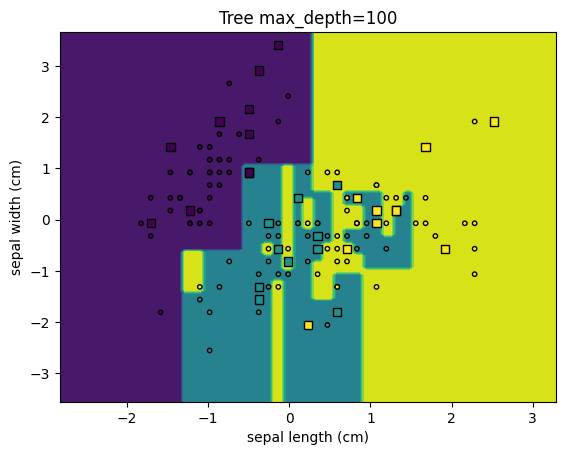

In [ ]:
tree = DecisionTreeClassifier(max_depth=100,
                              random_state=random_state)

tree.fit(X_train, y_train)
print (f'Train acc: {tree.score(X_train, y_train)}')
print (f'Test acc:  {tree.score(X_test, y_test)}')

print (classification_report(y_test, tree.predict(X_test)))

### 決定境界をプロット
display = DecisionBoundaryDisplay.from_estimator(tree, X_train, )

### train データをプロット
display.ax_.scatter(X_train.iloc[:, 0],
                    X_train.iloc[:, 1],
                    c=y_train, edgecolor="k", marker='o', s=10)
### test データをプロット
display.ax_.scatter(X_test.iloc[:, 0],
                    X_test.iloc[:, 1],
                    c=y_test, edgecolor="k", marker='s')
### タイトル
display.ax_.set_title('Tree max_depth=100')
plt.show()

Train-testデータそれぞれの正解率を比べると、testデータの正解率がtrainデータよりも低くなっており、過学習の兆候がみえる。

プロットした決定境界を見ると、trainデータ点（〇）を分けるように境界が複雑に入り組んでいる。
その結果、testデータ点（□）を正しく分類できていない領域ができている。